<a href="https://colab.research.google.com/github/decomiteA/ReachRLToolbox/blob/main/TestRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook models reaching movement using reinforcement learning algorithms

In [ ]:
#@title Imports

import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import convolve as conv

import torch
import torch.nn as nn
import torch.nn.functional as F

from replay_buffer import ReplayMemory # to resolve.... 
from time import perf_counter

ModuleNotFoundError: ignored

In [ ]:
#@title Plot handling

def plot_state_action_values(env, value, ax=None):
  """
  Generate plot showing value of each action at each state.
  """
  if ax is None:
    fig, ax = plt.subplots()

  for a in range(env.n_actions):
    ax.plot(range(env.n_states), value[:, a], marker='o', linestyle='--')
  ax.set(xlabel='States', ylabel='Values')
  ax.legend(['R','U','L','D'], loc='lower right')

def plot_quiver_max_action(env,value,ax=None):
  """
  Generate plot showing action of maximum value or maximum probability for each state
  """
  if ax is None: 
    fig, ax = plt.subplots()

  X = np.tile(np.arange(env.dim_x),[env.dim_y,1])+0.5
  Y = np.tile(np.arange(env.dim_y)[::-1][:,np.newaxis],[1,env.dim_x])
  which_max = np.reshape(value.argmax(axis=1),(env.dim_y,env.dim_x))
  which_max = which_max[::-1,:]
  U = np.zeros(X.shape)
  V = np.zeros(Y.shape)
  U[which_max == 0] = 1
  V[which_max == 1] = 1
  U[which_max == 2] = -1
  V[which_max == 3] = -1

  ax.quiver(X,Y,U,V)
  ax.set(
      title='Maximum value/probability actions',
      xlim = [-0.5, env.dim_x+0.5],
      ylim = [-0.5, env.dim_y+0.5],
  )
  ax.set_xticks(np.linspace(0.5, env.dim_x-0.5, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_xticks(np.arange(env.dim_x+1), minor=True)
  ax.set_yticks(np.linspace(0.5, env.dim_y-0.5, num=env.dim_y))
  ax.set_yticklabels(["%d" % y for y in np.arange(0, env.dim_y*env.dim_x,
                                                  env.dim_x)])
  ax.set_yticks(np.arange(env.dim_y+1), minor=True)
  ax.grid(which='minor',linestyle='-')

  
def plot_heatmap_max_val(env, value, ax=None):
  """
  Generate heatmap showing maximum value at each state
  """
  if ax is None:
    fig, ax = plt.subplots()

  if value.ndim == 1:
      value_max = np.reshape(value, (env.dim_y,env.dim_x))
  else:
      value_max = np.reshape(value.max(axis=1), (env.dim_y,env.dim_x))
  value_max = value_max[::-1,:]

  im = ax.imshow(value_max, aspect='auto', interpolation='none', cmap='afmhot')
  ax.set(title='Maximum value per state')
  ax.set_xticks(np.linspace(0, env.dim_x-1, num=env.dim_x))
  ax.set_xticklabels(["%d" % x for x in np.arange(env.dim_x)])
  ax.set_yticks(np.linspace(0, env.dim_y-1, num=env.dim_y))
  if env.name != 'windy_cliff_grid':
      ax.set_yticklabels(
          ["%d" % y for y in np.arange(
              0, env.dim_y*env.dim_x, env.dim_x)][::-1])
  return im


def plot_rewards(n_episodes, rewards, average_range=10, ax=None):
  """
  Generate plot showing total reward accumulated in each episode.
  """
  if ax is None:
    fig, ax = plt.subplots()

  smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)

  ax.plot(range(0, n_episodes, average_range),
          smoothed_rewards[0:n_episodes:average_range],
          marker='o', linestyle='--')
  ax.set(xlabel='Episodes', ylabel='Total reward')


def plot_performance(env, value, reward_sums):
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
  plot_state_action_values(env, value, ax=axes[0])
  #plot_quiver_max_action(env, value, ax=axes[0,1])
  plot_rewards(n_episodes, reward_sums, ax=axes[1])
  #im = plot_heatmap_max_val(env, value, ax=axes[1,1])
  #fig.colorbar(im)

The section of code below defines the different environment as objects with their own functions. Each environment is explained in the comments

In [ ]:
#@title Environments definition

class ToyExample:
  """
  This class defines the toy example that consists of a 4x4 grid with one good target state
  Here are the different states : 
  12 13 14 15
  8  9  10 11
  4  5  6  7
  1  2  3  4
  """
  def __init__(self):
    self.name="ToyExample1"
    self.n_states=16
    self.n_actions=4
    self.dim_x=4
    self.dim_y=5
    self.init_state=0

  def get_outcome(self,state,action):
    """
    This function returns the outcome of taking an action in a given state (returns reward and next_state)
    """
    if (state==14 or state==11 or state==12): 
      reward = 0
      next_state = None
      return next_state,reward 

    reward = -1 #we penalise any other action
    if action==0:   #move right
      if state%4==3: #right border 
        next_state=state
      else:
        next_state=state+1
      
    elif action==1: #move up
      if state>11:
        next_state=state
      else:
        next_state=state+4
      
    elif action==2: #move left
      if state%4==0: 
        next_state=state
      else:
        next_state=state-1
    
    elif action==3: #move down
      if state<4:
        next_state=state
      else:
        next_state=state-4
      
    else:
      print("Incorrect action, the selected action should be between 0 and 3")
      next_state=None
      reward=None
    return int(next_state) if next_state is not None else None, reward

  def get_all_outcomes(self):
    outcomes={}
    for state in range(self.n_states):
      for action in range(self.n_actions):
        next_state,reward = self.get_outcome(state,action)
        outcomes[state,action]=[(1,next_state,reward)]
    return outcomes

  


In [ ]:
#@title Policies 

def epsilon_greedy(q,epsilon):
  """
  This function implements the epsilong greedy policy
  """
  if np.random.random()>epsilon:
    action=np.argmax(q)
  else:
    action=np.random.choice(len(q))
  
  return action

def greedy(q):
  """
  This function implements the greedy (aka optimal policy)
  """
  return np.argmax(q)

In [ ]:
#@title Learning the environment

def learn_environment(env,learning_rule,params,max_steps,n_episodes):
  """
  This function learns the environment that the agent interacts with
  """
  value = np.ones((env.n_states,env.n_actions)) # initialize the qfunction

  reward_sums = np.zeros(n_episodes) # this table will contains the total reward of each episode

  # loop over the episodes
  for episode in range(n_episodes):
    state=env.init_state
    reward_sum=0
    for t in range(max_steps):
      #choose next action
      action = epsilon_greedy(value[state],params['epsilon'])
      #observe outcome of action on environment
      next_state, reward = env.get_outcome(state,action)
      #update value function
      value = learning_rule(state,action,reward,next_state,value,params)
      #sum rewards obtained
      reward_sum +=reward

      if next_state is None:
        reward_sum += 0
        break
      state = next_state
  
    reward_sums[episode] = reward_sum

  return value, reward_sums

def simulate_episode(env,params,max_steps):
  state_history=np.zeros(max_steps)
  state=env.init_state
  reward_sum=0
  for t in range(max_steps):
    action = epsilon_greedy(value[state],params['epsilon'])
    next_state,reward=env.get_outcome(state,action)
    reward_sum += reward_sum  

    if next_state is None:
      reward_sum +=0
      break
    state_history[t]=state
    state=next_state

  return state_history,reward_sum  


In [ ]:
#@title Different learning rules

def q_learning(state,action,reward,next_state,value,params):
  """
  This function implements the q-learning algorithm
  """
  q=value[state,action]
  if next_state is None:
    max_next_q = 0
  else:
    max_next_q = np.max(value[next_state])
  
  #compute td error
  td_error = reward + params['gamma']*max_next_q-q

  #update q value
  value[state,action] = q+params['alpha']*td_error
  return value

[[-4.08928624e+00 -2.71000000e+00 -3.43900000e+00 -3.43900000e+00]
 [-3.43424774e+00 -3.43452932e+00 -3.43437891e+00 -3.83723059e+00]
 [-2.70728179e+00 -2.70739254e+00 -3.46175339e+00 -2.93280789e+00]
 [-2.19681093e+00 -1.89921007e+00 -2.62703078e+00 -2.05034493e+00]
 [-3.43744044e+00 -1.90000000e+00 -2.71000000e+00 -3.43900000e+00]
 [-2.70871770e+00 -2.70876345e+00 -2.70883116e+00 -3.75126314e+00]
 [-1.89918347e+00 -1.89913504e+00 -3.05620429e+00 -3.10042860e+00]
 [-1.59939999e+00 -9.99749012e-01 -1.98984325e+00 -2.13488627e+00]
 [-2.70911746e+00 -1.00000000e+00 -1.90000000e+00 -2.71000000e+00]
 [-1.89929610e+00 -1.89927404e+00 -1.89929793e+00 -3.16586837e+00]
 [-9.99572983e-01 -9.99545708e-01 -2.03843518e+00 -2.26781488e+00]
 [ 1.43341120e-04  1.59267911e-04  1.59267911e-04  1.59267911e-04]
 [ 1.64380490e-50  1.64380490e-50  1.82644989e-50  1.82644989e-50]
 [-9.99506578e-01 -1.36918837e+00 -9.99480410e-01 -2.33471882e+00]
 [ 2.42749445e-04  2.42749445e-04  2.42749445e-04  2.42749445e

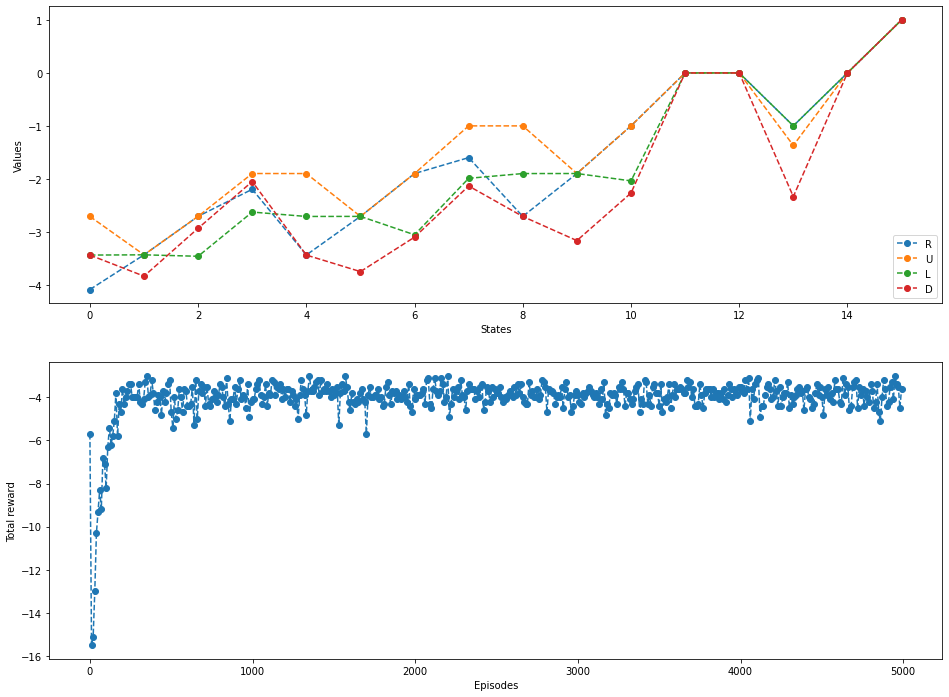

In [ ]:
params = {
    'epsilon':0.2,
    'alpha':0.1,
    'gamma':0.9,
}

env_test = ToyExample()
n_episodes = 5000
max_steps = 50
value_qlearning,reward_sums_qlearning = learn_environment(env_test,q_learning,params,max_steps,n_episodes)

plot_performance(env_test,value_qlearning,reward_sums_qlearning)
print(value_qlearning)

state_history,reward_sum = simulate_episode(env_test,params,max_steps)
print(state_history)

From here below we will investigate the implementation of reinforcement learning using neural networks. Here is the outline of the methods tested in chronological order 


1. double dqn (inspired from Nathan Cloos' one)



In [ ]:
#@title Double DQN

class CNN_DQN(nn.module):
  def __init__(self,input_shape,n_outputs,config):
    super(CNN_DQN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(3,16,(2,2)),
        nn.ReLU(),
        nn.Conv2d(16,32,(2,2))
        nn.ReLU(),
        nn.Conv2d(32,64,(2,2)),
        nn.ReLU()
    )
    conv_out_size = self._get_conv_out((input_shape[2],*input_shape[:2]))

    self.dueling = config['dueling']
    if not self.dueling:
      self.fc_layers=nn.Sequential(
          nn.Linear(conv_out_size,64),
          nn.ReLU(),
          nn.Linear(64, n_outputs)
      )
    else:
      self.fc_A = nn.Sequential(
          nn.Linear(conv_out_size,64),
          nn.ReLU(),
          nn.Linear(64,n_outputs)
      )
      self.fc_V=nn.Sequential(
          nn.Linear(conv_out_size,64),
          nn.ReLU(),
          nn.Linear(64,1)
      )
    
  def _get_conv_out(self,shape):
    o = self.conv_layers(torch.zeros(1,*shape))
    return int(np.prod(o.size()))




  def forward(self,x):
    x = x.transpose(1,3).transpose(2,3)
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0],-1)
    if not self.dueling:
      x=self.fc_layers(x)
    else:
      V = self.fc_V(x)
      A = self.fc_A(x)
      x = V + A - A.mean()
    return x
  
class DQN(nn.Module):
  def __init__(self,input_shape,n_outputs,config):
    super(DQN,self).__init__()
    n_hidden=config['n_hidden']
    self.fc1 = nn.Linear(np.prod(input_shape),n_hidden)
    self.fc2 = nn.Linear(n_hidden,n_hidden)
    self.fc3 = nn.Linear(n_hidden,n_outputs)

  def forward(self,x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

class DQNAgent():
  def __init__(self,obs_shape,n_actions,log_writer,config,device='cpu'):


  def select_action(self,obs,iter):


  def training_step(self,obs,action,reward,next_obs,done,iter):

      
